<a href="https://colab.research.google.com/github/mazzeratziii/ML/blob/main/MO_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv('/content/drive/MyDrive/ColabFiles/Lab3.csv')
print("Размер данных:", df.shape)
print("\nПервые 5 строк")
print(df.head())
print("\nИнформация о данных")
print(df.info())
print("\nСтатистика числовых переменных")
print(df.describe())
print("\nДубликаты:", df.duplicated().sum())
print("\nТипы данных:")
print(df.dtypes)

Размер данных: (167, 10)

Первые 5 строк
               country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  
0       9.44        56.2       5.82    553  
1       4.49        76.3       1.65   4090  
2      16.10        76.5       2.89   4460  
3      22.40        60.1       6.16   3530  
4       1.44        76.8       2.13  12200  

Информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   ch

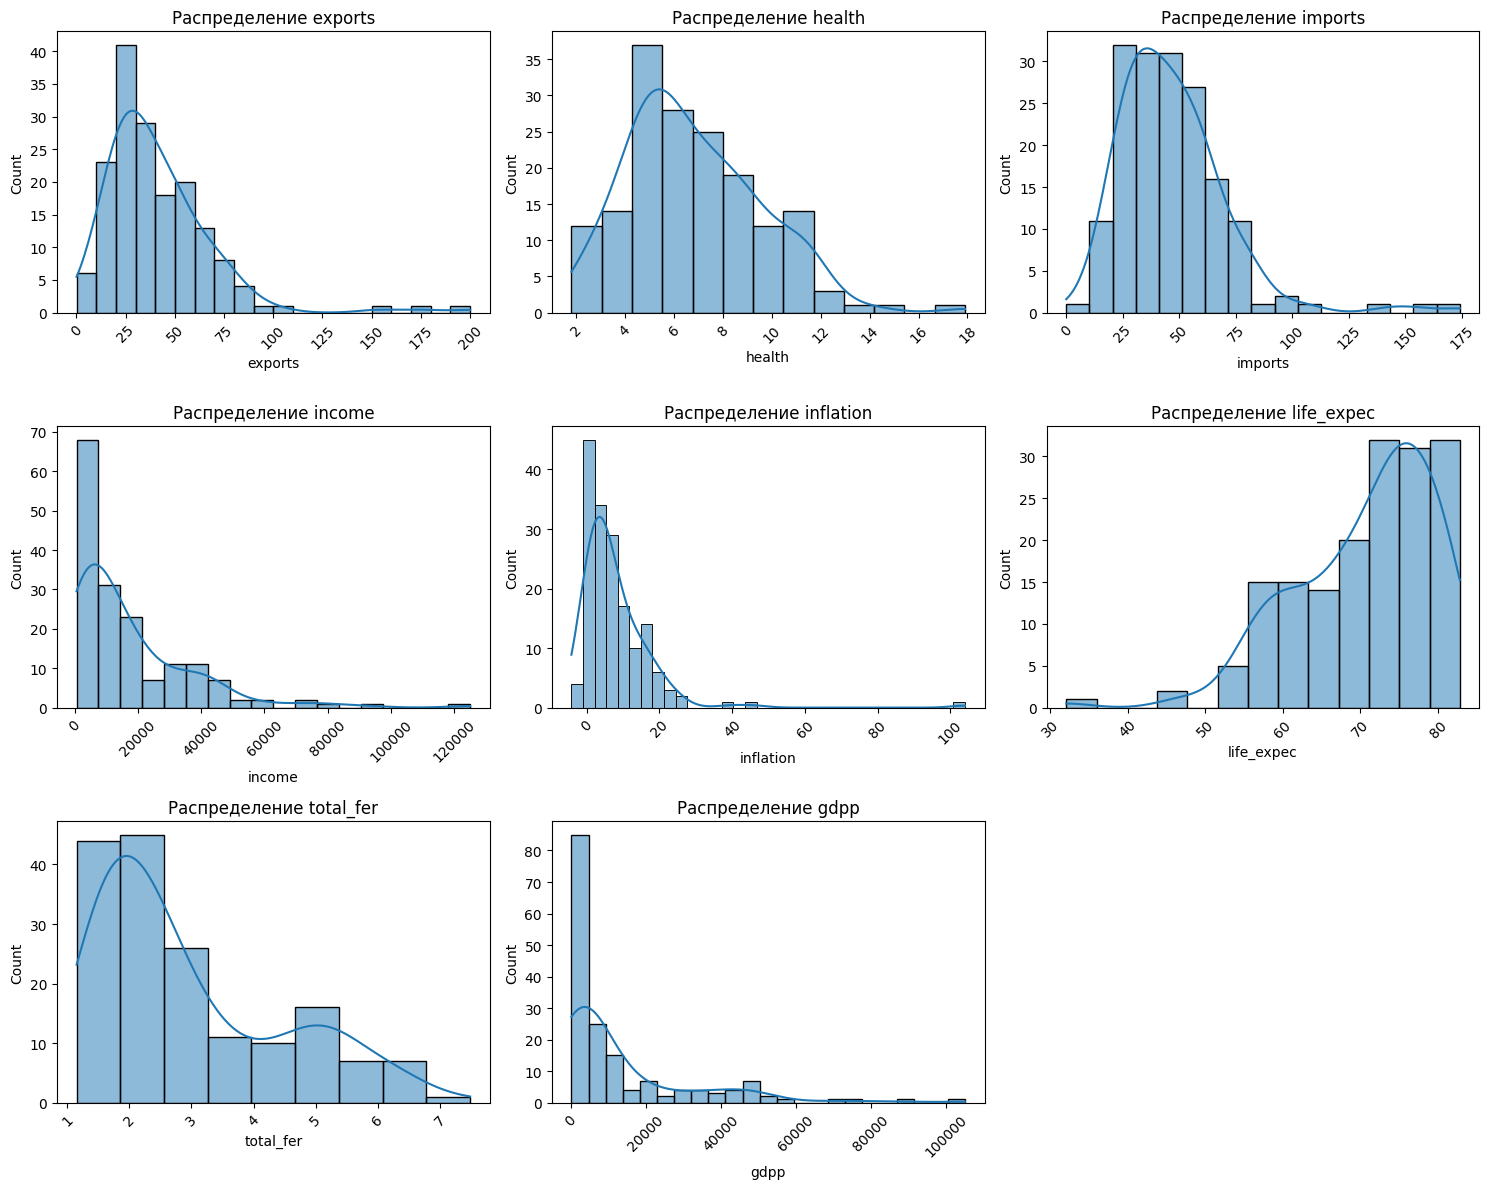

In [ ]:
# Визуализация распределения переменных
plt.figure(figsize=(15, 12))
numeric_cols = df.select_dtypes(include=[np.number]).columns

for i, col in enumerate(numeric_cols[1:], 1):  # пропускаем name
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Распределение {col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

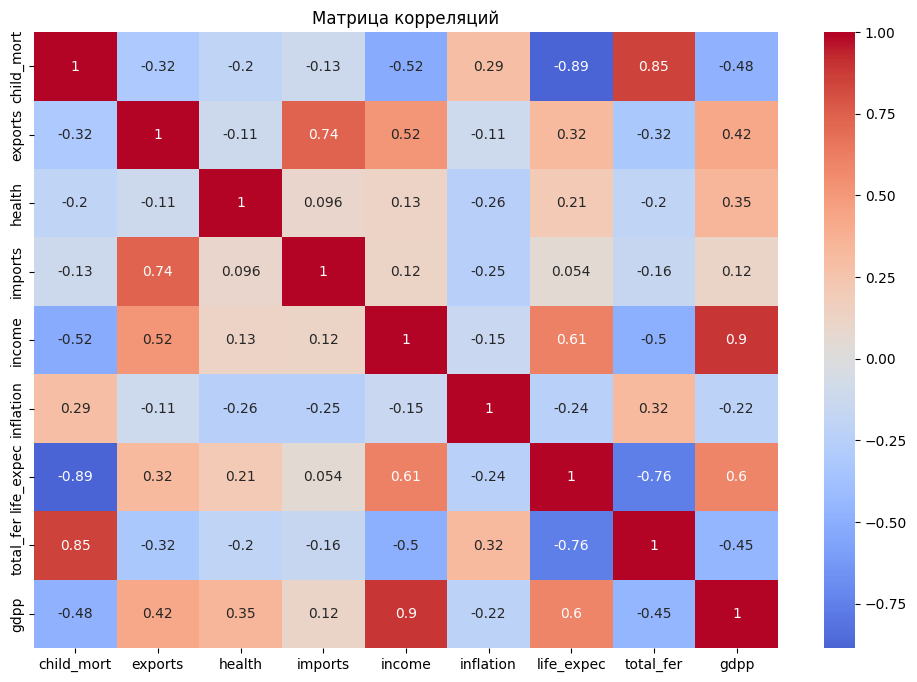

In [ ]:
# Матрица корреляций
plt.figure(figsize=(12, 8))
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляций')
plt.show()

In [ ]:
# Обработка пропусков
df_clean = df.drop_duplicates().copy()
# Удаление столбца country для кластеризации
X = df_clean.drop('country', axis=1)

# Нормализация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Минимакс нормализация для некоторых методов
minmax_scaler = MinMaxScaler()
X_minmax = minmax_scaler.fit_transform(X)

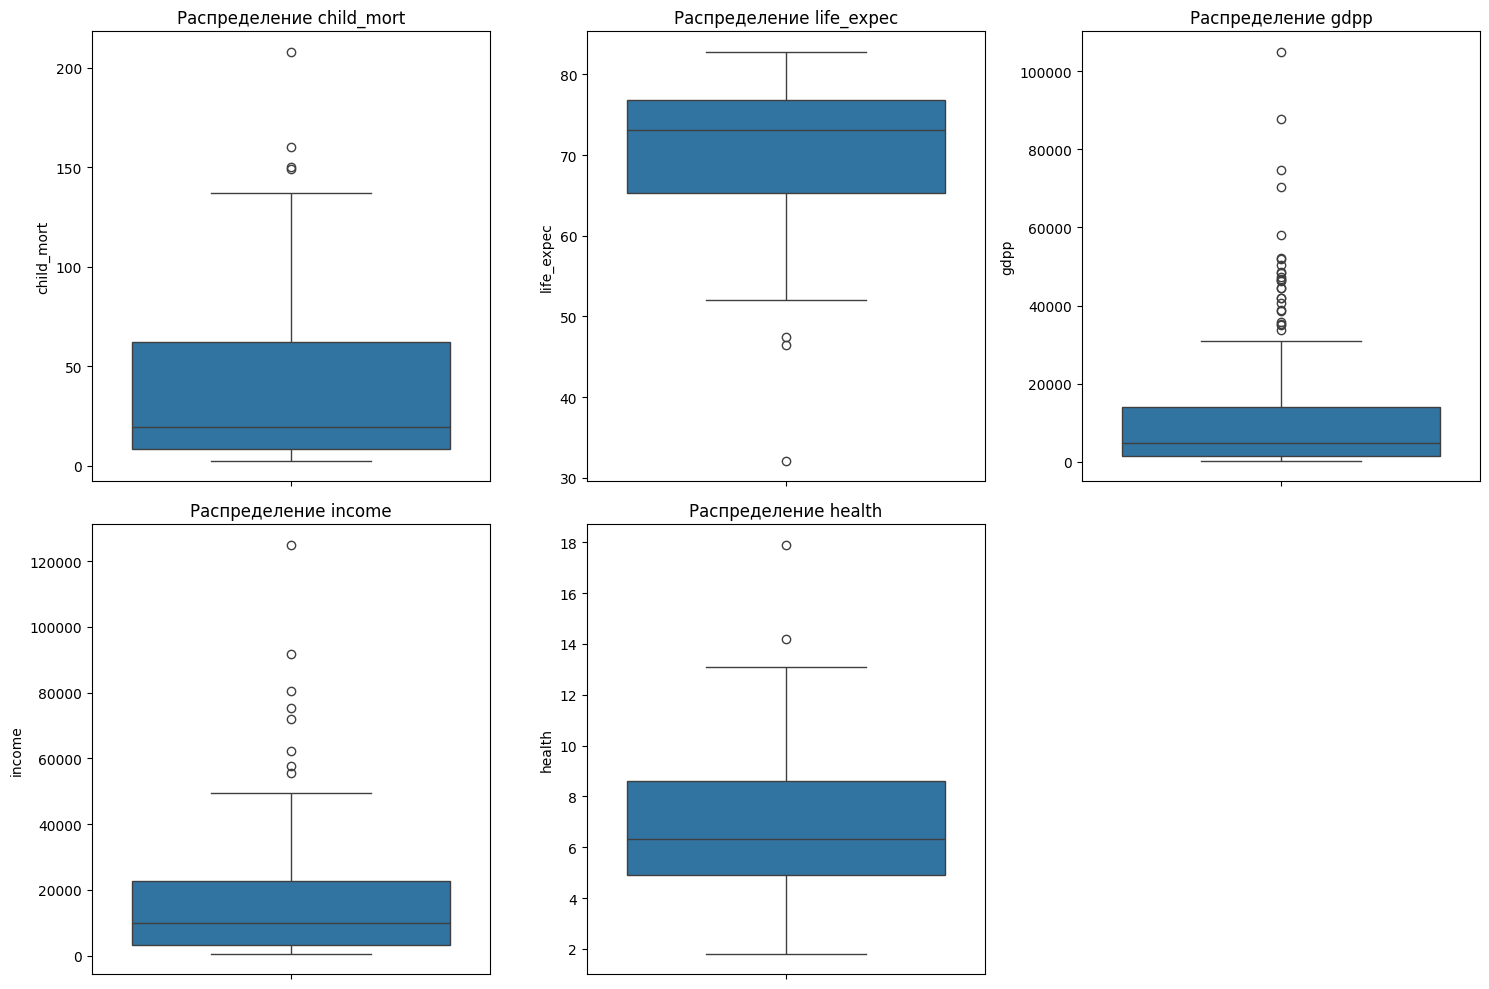

In [ ]:
# Анализ ключевых показателей для благотворительности
key_metrics = ['child_mort', 'life_expec', 'gdpp', 'income', 'health']

plt.figure(figsize=(15, 10))
for i, metric in enumerate(key_metrics, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df_clean[metric])
    plt.title(f'Распределение {metric}')
plt.tight_layout()
plt.show()

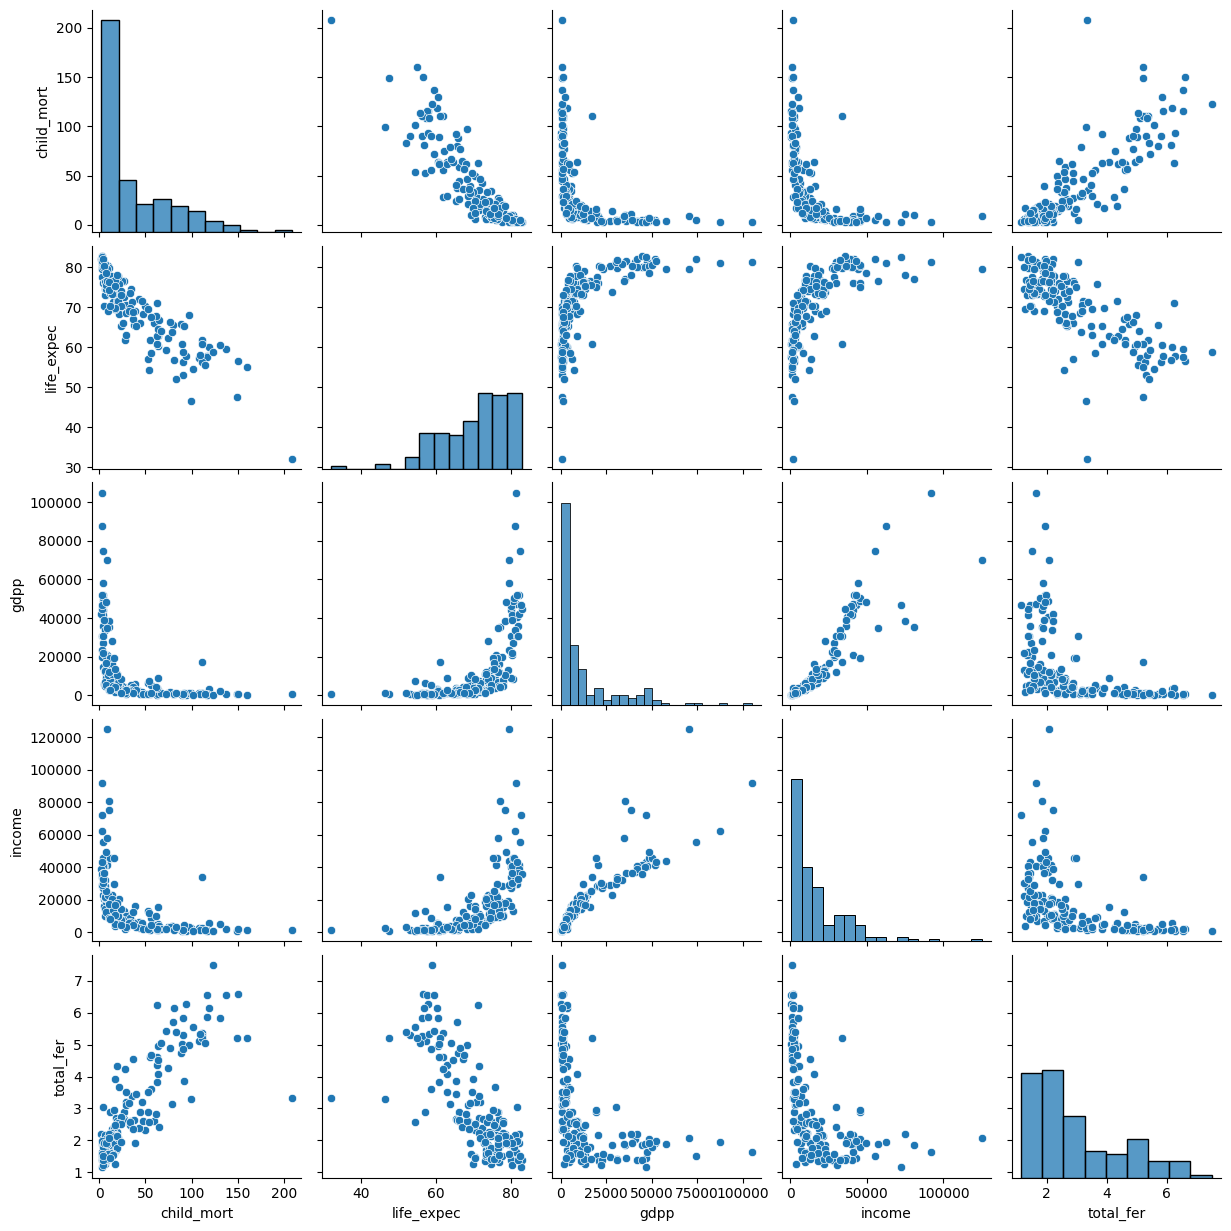

In [ ]:
# Визуализация взаимосвязей ключевых показателей
sns.pairplot(df[['child_mort', 'life_expec', 'gdpp', 'income', 'total_fer']])
plt.show()

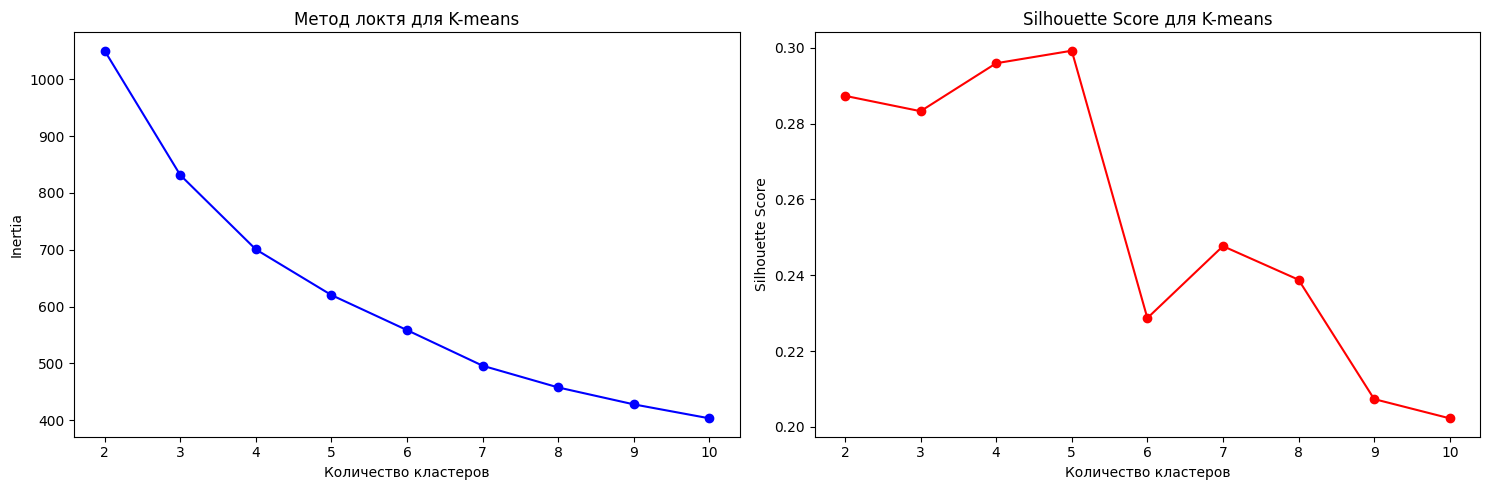

In [ ]:
# Определение оптимального количества кластеров для K-means
inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# График локтя и силуэта
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(k_range, inertia, 'bo-')
ax1.set_xlabel('Количество кластеров')
ax1.set_ylabel('Inertia')
ax1.set_title('Метод локтя для K-means')

ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Количество кластеров')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score для K-means')

plt.tight_layout()
plt.show()

In [ ]:
# Применение K-means с оптимальным количеством кластеров
optimal_k = 4  # на основе графиков
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# MiniBatch K-means
minibatch_kmeans = MiniBatchKMeans(n_clusters=optimal_k, random_state=42, n_init=3)
minibatch_labels = minibatch_kmeans.fit_predict(X_scaled)

# Добавление результатов в DataFrame
df_clean['kmeans_cluster'] = kmeans_labels
df_clean['minibatch_cluster'] = minibatch_labels

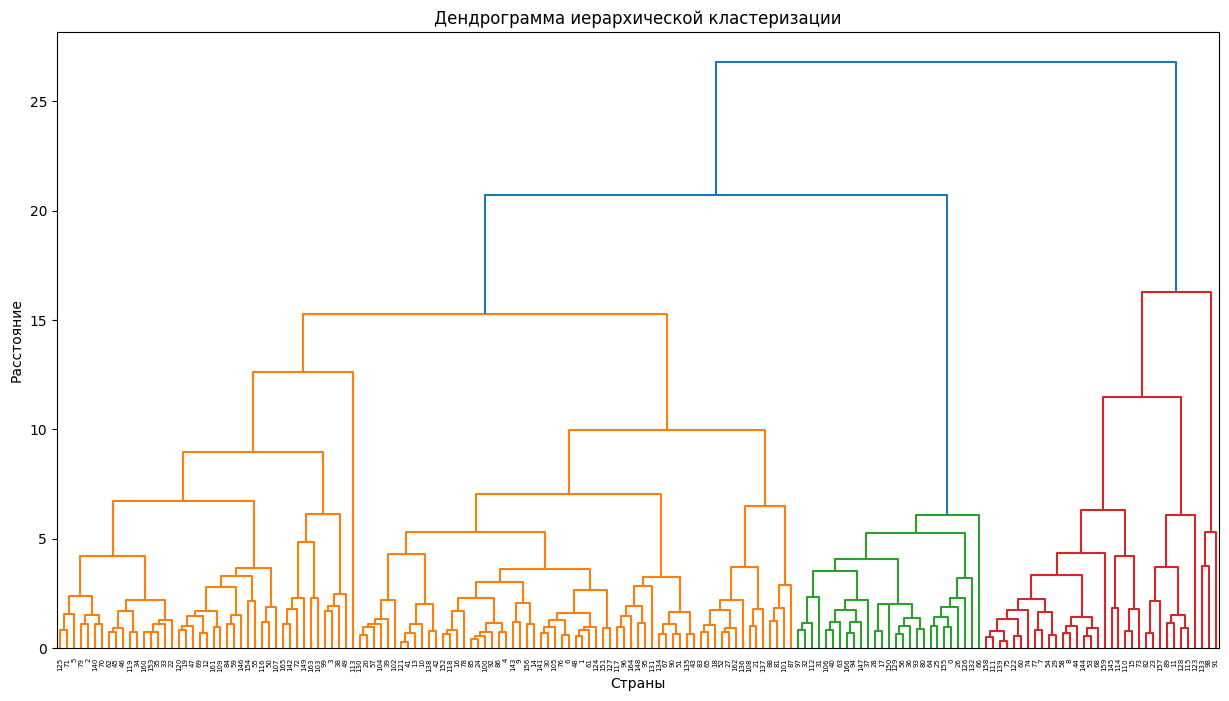

In [ ]:
# Дендрограмма для определения количества кластеров
plt.figure(figsize=(15, 8))
linked = linkage(X_scaled, method='ward')
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Дендрограмма иерархической кластеризации')
plt.xlabel('Страны')
plt.ylabel('Расстояние')
plt.show()

In [ ]:
# Применение иерархической кластеризации
hierarchical_labels = fcluster(linked, t=optimal_k, criterion='maxclust')
df_clean['hierarchical_cluster'] = hierarchical_labels - 1  # приводим к 0-based

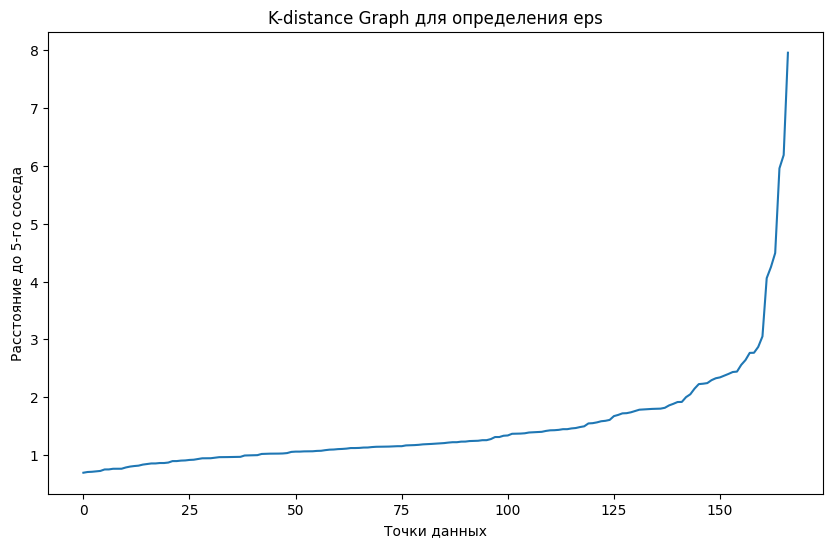

In [ ]:
# Подбор параметров для DBSCAN
from sklearn.neighbors import NearestNeighbors

# Анализ расстояний для определения eps
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

distances = np.sort(distances[:, -1], axis=0)
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('K-distance Graph для определения eps')
plt.xlabel('Точки данных')
plt.ylabel('Расстояние до 5-го соседа')
plt.show()

In [ ]:
# Применение DBSCAN
dbscan = DBSCAN(eps=2.0, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

print(f"Количество кластеров DBSCAN: {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}")
print(f"Выбросы: {list(dbscan_labels).count(-1)}")

df_clean['dbscan_cluster'] = dbscan_labels

Количество кластеров DBSCAN: 1
Выбросы: 15


In [ ]:
# Анализ кластеров по ключевым показателям
def analyze_clusters(df, cluster_col, method_name):
    print(f"\nАнализ кластеров для {method_name}")

    cluster_stats = df.groupby(cluster_col).agg({
        'child_mort': ['mean', 'std'],
        'life_expec': ['mean', 'std'],
        'gdpp': ['mean', 'std'],
        'income': ['mean', 'std'],
        'health': ['mean', 'std']
    }).round(2)

    print(cluster_stats)

    # Определение наиболее нуждающегося кластера
    neediness_score = df.groupby(cluster_col).agg({
        'child_mort': 'mean',
        'life_expec': lambda x: 1/x.mean(),
        'gdpp': lambda x: 1/x.mean(),
        'income': lambda x: 1/x.mean()
    })

    neediness_score['combined_score'] = neediness_score.mean(axis=1)
    most_needy_cluster = neediness_score['combined_score'].idxmax()

    print(f"\nНаиболее нуждающийся кластер: {most_needy_cluster}")
    return most_needy_cluster

# Анализ для каждого метода
methods = {
    'kmeans_cluster': 'K-means',
    'minibatch_cluster': 'MiniBatch K-means',
    'hierarchical_cluster': 'Иерархическая кластеризация',
    'dbscan_cluster': 'DBSCAN'
}

needy_clusters = {}
for cluster_col, method_name in methods.items():
    needy_clusters[method_name] = analyze_clusters(df_clean, cluster_col, method_name)


Анализ кластеров для K-means
               child_mort        life_expec            gdpp            \
                     mean    std       mean   std      mean       std   
kmeans_cluster                                                          
0                    5.18   2.63      80.08  1.87  42118.75  15347.24   
1                   92.96  33.38      59.19  6.44   1922.38   2956.10   
2                   21.69  13.82      72.87  3.96   6519.55   4798.58   
3                    4.13   2.31      81.43  1.21  57566.67  43011.67   

                  income           health        
                    mean       std   mean   std  
kmeans_cluster                                   
0               44021.88  19749.12   9.09  3.17  
1                3942.40   5641.79   6.39  2.66  
2               12671.41   8746.15   6.20  2.17  
3               64033.33  32460.64   6.79  2.49  

Наиболее нуждающийся кластер: 1

Анализ кластеров для MiniBatch K-means
                  child_mort       

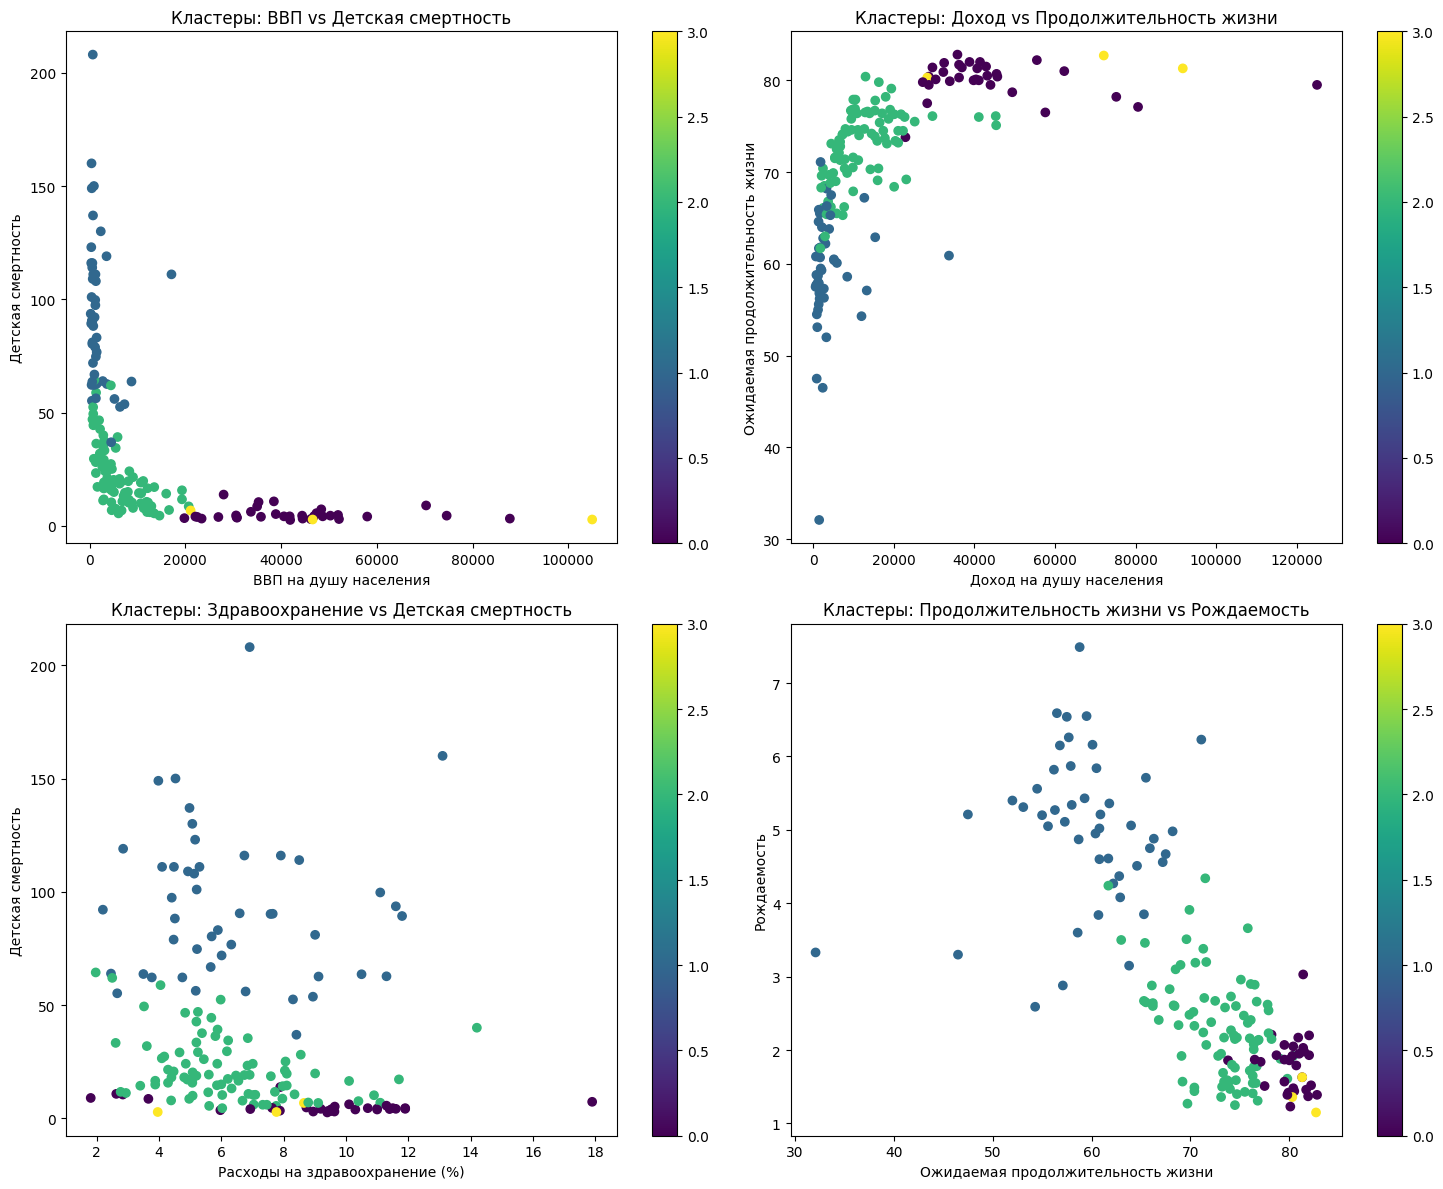

In [ ]:
# Визуализация кластеров K-means (как наиболее стабильного метода)
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# child_mort vs gdpp
scatter = axes[0,0].scatter(df_clean['gdpp'], df_clean['child_mort'],
                           c=df_clean['kmeans_cluster'], cmap='viridis')
axes[0,0].set_xlabel('ВВП на душу населения')
axes[0,0].set_ylabel('Детская смертность')
axes[0,0].set_title('Кластеры: ВВП vs Детская смертность')
plt.colorbar(scatter, ax=axes[0,0])

# life_expec vs income
scatter = axes[0,1].scatter(df_clean['income'], df_clean['life_expec'],
                           c=df_clean['kmeans_cluster'], cmap='viridis')
axes[0,1].set_xlabel('Доход на душу населения')
axes[0,1].set_ylabel('Ожидаемая продолжительность жизни')
axes[0,1].set_title('Кластеры: Доход vs Продолжительность жизни')
plt.colorbar(scatter, ax=axes[0,1])

# health vs child_mort
scatter = axes[1,0].scatter(df_clean['health'], df_clean['child_mort'],
                           c=df_clean['kmeans_cluster'], cmap='viridis')
axes[1,0].set_xlabel('Расходы на здравоохранение (%)')
axes[1,0].set_ylabel('Детская смертность')
axes[1,0].set_title('Кластеры: Здравоохранение vs Детская смертность')
plt.colorbar(scatter, ax=axes[1,0])

# total_fer vs life_expec
scatter = axes[1,1].scatter(df_clean['life_expec'], df_clean['total_fer'],
                           c=df_clean['kmeans_cluster'], cmap='viridis')
axes[1,1].set_xlabel('Ожидаемая продолжительность жизни')
axes[1,1].set_ylabel('Рождаемость')
axes[1,1].set_title('Кластеры: Продолжительность жизни vs Рождаемость')
plt.colorbar(scatter, ax=axes[1,1])

plt.tight_layout()
plt.show()

In [ ]:
# Используем K-means как наиболее стабильный метод
most_needy_cluster_kmeans = needy_clusters['K-means']

needy_countries = df_clean[df_clean['kmeans_cluster'] == most_needy_cluster_kmeans].copy()

# Ранжирование стран внутри нуждающегося кластера
needy_countries['neediness_rank'] = (
    needy_countries['child_mort'].rank(ascending=False) +
    needy_countries['gdpp'].rank(ascending=True) +
    needy_countries['income'].rank(ascending=True) +
    needy_countries['life_expec'].rank(ascending=True) +
    (1 / needy_countries['health']).rank(ascending=False)
)

needy_countries = needy_countries.sort_values('neediness_rank')

print("Страны для первоочередной помощи:")

for i, (idx, country) in enumerate(needy_countries.head(20).iterrows(), 1):
    print(f"{i:2d}. {country['country']:20} | "
          f"Дет.смертн.: {country['child_mort']:5.1f} | "
          f"ВВП: ${country['gdpp']:6.0f} | "
          f"Прод.жизни: {country['life_expec']:4.1f}")

# Описание кластеров
print("\Описание кластеров:")

for cluster in range(optimal_k):
    cluster_data = df_clean[df_clean['kmeans_cluster'] == cluster]
    print(f"\nКластер {cluster} ({len(cluster_data)} стран):")
    print(f"Средняя детская смертность: {cluster_data['child_mort'].mean():.1f}")
    print(f"Средний ВВП на душу: ${cluster_data['gdpp'].mean():.0f}")
    print(f"Средняя продолжительность жизни: {cluster_data['life_expec'].mean():.1f} лет")
    print(f"Средний доход: ${cluster_data['income'].mean():.0f}")

    # Эталонная страна (ближайшая к центроиду)
    centroid = kmeans.cluster_centers_[cluster]
    distances = np.linalg.norm(X_scaled[df_clean['kmeans_cluster'] == cluster] - centroid, axis=1)
    representative_idx = distances.argmin()
    representative_country = cluster_data.iloc[representative_idx]['country']
    print(f"Эталонная страна: {representative_country}")

Страны для первоочередной помощи:
 1. Central African Republic | Дет.смертн.: 149.0 | ВВП: $   446 | Прод.жизни: 47.5
 2. Niger                | Дет.смертн.: 123.0 | ВВП: $   348 | Прод.жизни: 58.8
 3. Mozambique           | Дет.смертн.: 101.0 | ВВП: $   419 | Прод.жизни: 54.5
 4. Congo, Dem. Rep.     | Дет.смертн.: 116.0 | ВВП: $   334 | Прод.жизни: 57.5
 5. Haiti                | Дет.смертн.: 208.0 | ВВП: $   662 | Прод.жизни: 32.1
 6. Malawi               | Дет.смертн.:  90.5 | ВВП: $   459 | Прод.жизни: 53.1
 7. Sierra Leone         | Дет.смертн.: 160.0 | ВВП: $   399 | Прод.жизни: 55.0
 8. Guinea               | Дет.смертн.: 109.0 | ВВП: $   648 | Прод.жизни: 58.0
 9. Chad                 | Дет.смертн.: 150.0 | ВВП: $   897 | Прод.жизни: 56.5
10. Guinea-Bissau        | Дет.смертн.: 114.0 | ВВП: $   547 | Прод.жизни: 55.6
11. Burundi              | Дет.смертн.:  93.6 | ВВП: $   231 | Прод.жизни: 57.7
12. Burkina Faso         | Дет.смертн.: 116.0 | ВВП: $   575 | Прод.жизни: 57.9
13

In [ ]:
# Сводная таблица по кластерам
cluster_summary = df_clean.groupby('kmeans_cluster').agg({
    'child_mort': 'mean',
    'gdpp': 'mean',
    'life_expec': 'mean',
    'income': 'mean',
    'health': 'mean',
    'country': 'count'
}).round(2)

cluster_summary.columns = ['Дет_смертность', 'ВВП_на_душу', 'Прод_жизни','Доход', 'Здравоохранение', 'Кол-во_стран']
print("\nСводная таблица по кластерам:")
print(cluster_summary)




Сводная таблица по кластерам:
                Дет_смертность  ВВП_на_душу  Прод_жизни     Доход  \
kmeans_cluster                                                      
0                         5.18     42118.75       80.08  44021.88   
1                        92.96      1922.38       59.19   3942.40   
2                        21.69      6519.55       72.87  12671.41   
3                         4.13     57566.67       81.43  64033.33   

                Здравоохранение  Кол-во_стран  
kmeans_cluster                                 
0                          9.09            32  
1                          6.39            47  
2                          6.20            85  
3                          6.79             3  


Наиболее нуждающиеся страны характеризуются:

высокой смертностью (>50 на 1000)

Низким ВВП на душу населения (<2000$)

Низкой продолжительностью жизни (<65 лет)

Ограниченными расходами на здравохранение
